In [ ]:
# Wikipedia App

## "Map" Total Time with Extra Features

__Conclusion__: _TODO_

In [1]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from math import ceil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.linear_model import RidgeCV, LinearRegression
from lib import DataFrameBuilder
from lib import Humanizer, Plotter, Model, OneManyModel, TwoMeanModel, Outlier, ExperimentInfo, TaskMeanModel
from mynotebook import *

df_builder = DataFrameBuilder()

## Wikipedia Application

### Target

,input size (GiB),workers,samples,outliers,available
0,45,4,30,3,27
1,45,8,30,1,29
2,45,16,30,1,29
3,45,32,30,2,28
4,45,64,30,3,27


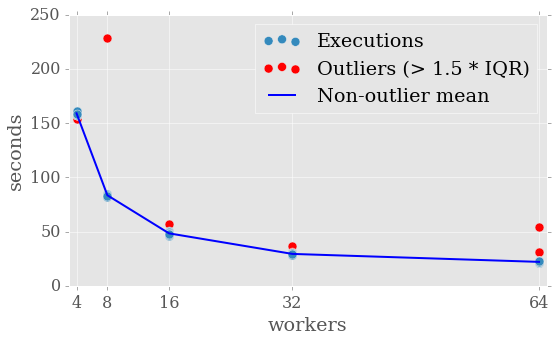

Total target application duration using the complete dataset (45 GB).


In [2]:
target_out = df_builder.get_target_df(stage=0)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((3, 65), (0, 250))
caption = 'Total target application duration using the complete dataset (45 GB).'
target = process_outliers(target_out, humanizer, plotter, caption)

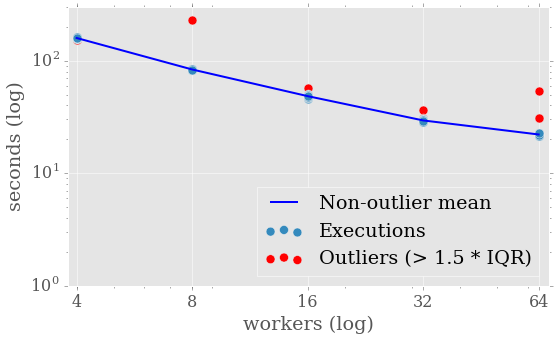

The same as above in log-log scale.


In [14]:
plotter = Plotter((3.8, 68), (1, 300), logx=True, logy=True, loc='lower right')
plotter.plot_outliers(target_out)
print('The same as above in log-log scale.')

### "Reduce" stage

In [48]:
caption = 'Stage duration'
prof_out = df_builder.get_strong_scaling_df(2, stage=0)

,input size (GiB),workers,samples,outliers,available
0,1,1,10,2,8
1,1,2,10,1,9
2,1,3,10,1,9


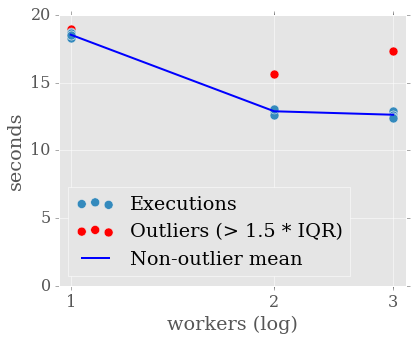

Stage duration


In [50]:
plotter = Plotter((0.96, 3.13), (0, 20), logx=True, logy=False, figsize=(6, 5))
prof = process_outliers(prof_out, Humanizer(), plotter, caption)

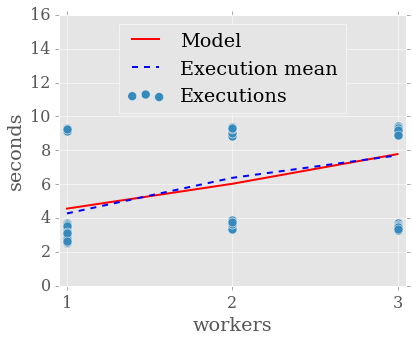

In [58]:
model = model_many
prof = prof_many

plotter = Plotter((0.95, 3.05), (0, 16), loc='upper center', figsize=(6, 5))
plotter.plot_model(model, prof)

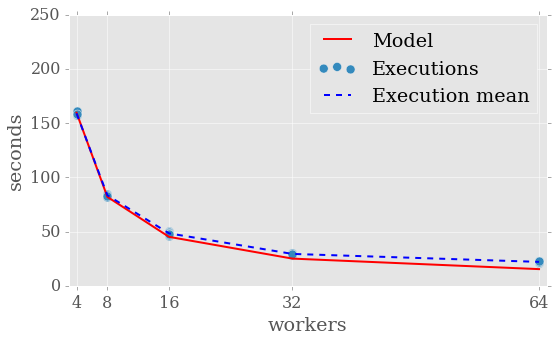

In [59]:
task_model = Model(RidgeCV(normalize=True), features=['workers'], ycol='ms', degree=2, use_log=False)
exp_info = ExperimentInfo(ExperimentInfo.SS2, 2, 128 * 1024**2)
prof_tasks = exp_info.get_n_tasks(stage=0)
target_tasks = exp_info.get_n_blocks(48542876756)
threads = exp_info.threads
stage_model = TaskMeanModel(task_model, prof_tasks, target_tasks, threads)

stage_model.fit(prof_many)
plotter = Plotter((3, 65), (0, 250))
plotter.plot_model(stage_model, target)

In [284]:
target_out = df_builder.get_target_df(stage=0)
prof_out = df_builder.get_strong_scaling_df(2, stage=0)
target = remove_outliers(target_out)
prof = remove_outliers(prof_out)

,ms,nonfirst_iterations
24,12497,1
11,12903,1
27,12465,1


,workers,input,ms,nonfirst_iterations
138,64,48542876756,21781,2
72,16,48542876756,48646,11
137,64,48542876756,21562,2


9863.3125000000036

array([ 2897.02083333])

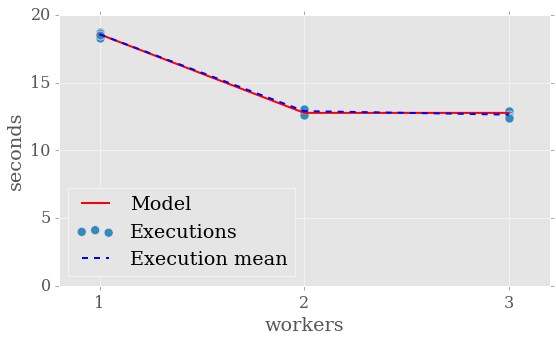

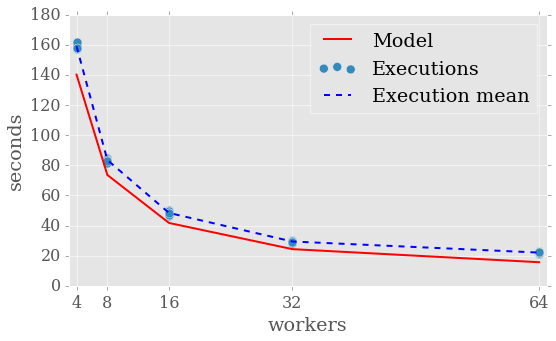

In [295]:
def add_features_map(df, exp_info):
    threads = exp_info.threads * df.workers
    tasks = np.ceil(df.input/exp_info.block_size)
    nonfirst = tasks - threads
    nonfirst[nonfirst < 0] = 0
    iterations = np.ceil(nonfirst/threads)
    _df = df.copy()
    _df['nonfirst_iterations'] = iterations.astype('int')
    return _df

exp_info = ExperimentInfo(ExperimentInfo.SS2, 2, 128 * 1024**2)
prof_extra = add_features_map(prof, exp_info).drop('input', axis=1).drop('workers', axis=1)
target_extra = add_features_map(target, exp_info)
display(prof_extra.sample(3))
display(target_extra.sample(3))
_model_stage = Model(LinearRegression(), ycol='ms', use_log=False)
_model_stage.fit(prof_extra)
linreg = _model_stage.get_linreg()
display(linreg.intercept_, linreg.coef_)

plotter = Plotter((0.8, 3.2), (0, 20))
prof_extra['workers'] = prof.workers
plotter.plot_model(_model_stage, prof_extra)
plotter = Plotter((3, 65), (None, None))
plotter.plot_model(_model_stage, target_extra)

,input size (GiB),workers,samples,outliers,available
0,0,1,10,0,10
1,0,1,10,0,10
2,0,1,10,1,9
3,1,1,10,2,8


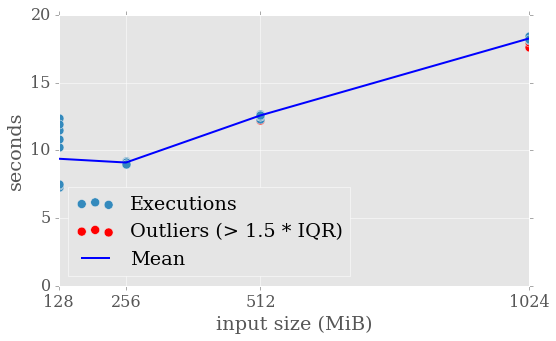

In [304]:

caption = ''
plotter = Plotter()
prof_one = process_outliers(prof_one_out, Humanizer(), plotter, caption)

In [352]:
target_out = df_builder.get_target_df(stage=0)
target = remove_outliers(target_out)

prof_many_out = df_builder.get_strong_scaling_df(2, stage=0)
prof_many = remove_outliers(prof_many_out)

prof_one_out = df_builder.get_1VM_df(stage=0)
prof_one = remove_outliers(prof_one_out)

In [353]:
prof = pd.concat([prof_one, prof_many])
prof = prof[prof.input > 200 * 1024**2]
#prof = prof_many

,input,ms,first_iterations,nonfirst_iterations
16,1073741798,12876,1,49
16,268425644,9011,1,99
31,1073741798,18279,1,99


,workers,input,ms,first_iterations,nonfirst_iterations
63,16,48542876756,48691,1,6
35,8,48542876756,84333,1,12
111,32,48542876756,29781,1,3


0.0

array([ 0.00061977,  0.00642682,  0.        ,  0.00401234,  0.01277178,
        0.        ,  0.03971618,  0.        ,  0.        ,  0.01765525,
        0.00019668,  0.        , -0.00201584,  0.        ,  0.        ,
       -0.00502638,  0.        ,  0.        ,  0.        ,  0.02443621])

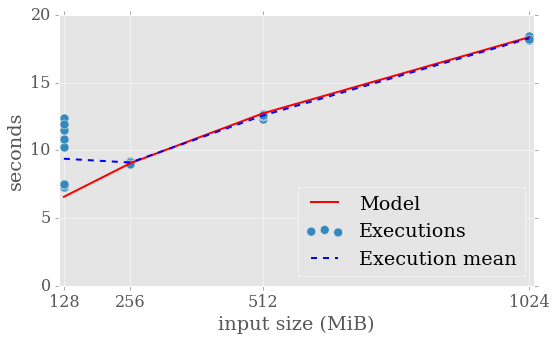

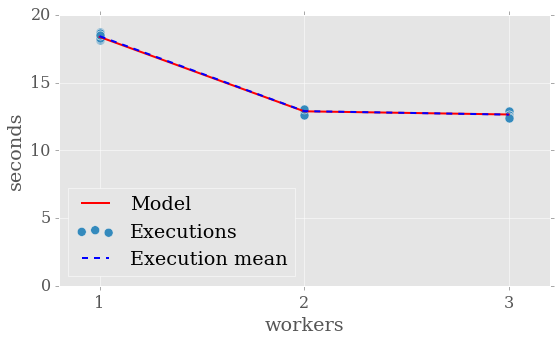

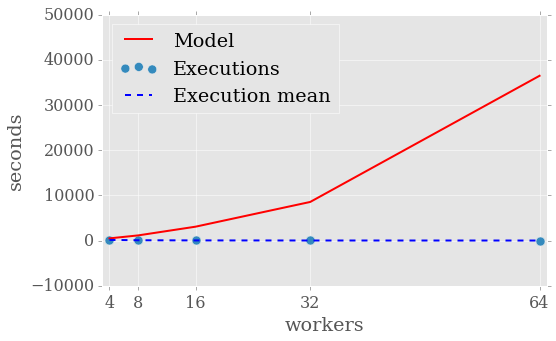

In [351]:
def add_features_reduce(df, exp_info):
    threads = exp_info.threads * df.workers
    tasks = exp_info.get_n_tasks(1)
    assert tasks == 200
    nonfirst = tasks - threads
    nonfirst[nonfirst < 0] = 0
    iterations = np.ceil(nonfirst/threads)
    _df = df.copy()
    _df['first_iterations'] = [1] * len(_df)
    _df['nonfirst_iterations'] = iterations.astype('int')
    return _df

exp_info = ExperimentInfo(ExperimentInfo.SS2, 2, 128 * 1024**2)
prof_extra = add_features_reduce(prof, exp_info).drop('workers', axis=1)#.drop('input', axis=1)
target_extra = add_features_reduce(target, exp_info)
display(prof_extra.sample(3))
display(target_extra.sample(3))
_model_stage = Model(RidgeCV(alphas=(1,),normalize=True, fit_intercept=False), ycol='ms', degree=3, use_log=True)
_model_stage.fit(prof_extra)
linreg = _model_stage.get_linreg()
display(linreg.intercept_, linreg.coef_)

plotter = Plotter((118, 1034))

prof_one_extra = add_features_reduce(prof_one, exp_info)
plotter.plot_model(_model_stage, prof_one_extra)

plotter = Plotter((0.8, 3.2), (0, 20))
prof_extra['workers'] = prof.workers
plotter.plot_model(_model_stage, prof_extra[prof_extra.input > 1000 * 1024**2])

plotter = Plotter((3, 65), (None, None))
plotter.plot_model(_model_stage, target_extra)